# ResNet-18 기반 네트워크 정의

In [2]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, Activation

def ResNet18(show_layers=False, **kwargs):
    '''
    # classification_models 패키지 설치
    
    pip install git+https://github.com/qubvel/classification_models.git
    
    '''
    from classification_models.keras import Classifiers

    ResNet18, preprocess_input = Classifiers.get('resnet18')
    
    base_model = ResNet18(**kwargs)
    x = GlobalAveragePooling2D()(base_model.output)
    pred = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=pred)
    model.compile(optimizer=SGD(lr=1e-3, decay=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    if show_layers:
        for i, layer in enumerate(model.layers):
            print(i, layer.name, layer.trainable)
    
    return model

# 네트워크 정보 요약

In [3]:
from keras.optimizers import SGD

model = ResNet18(input_shape=(224, 224, 3), weights=None, include_top=False)

model.summary()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\ysk00\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-a95512ddb500>", line 3, in <module>
    model = ResNet18(input_shape=(224, 224, 3), weights=None, include_top=False)
  File "<ipython-input-2-05c3d03710fa>", line 11, in ResNet18
    from classification_models.keras import Classifiers
ModuleNotFoundError: No module named 'classification_models'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ysk00\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ModuleNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ysk00\Anaconda3\lib\

ModuleNotFoundError: No module named 'classification_models'

# 모델 학습

# protocol_4 (total_data_test)

In [3]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'protocol_4'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'protocol_4'
    
    saveDir = 'trained_model__'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)#이미지augmentation > 이미지를 회전,확대,축소 등 여러변형해보는것.
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes) #np.unique는 중복원소제거하는거

    # callback 함수 정의 dropout함수
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

>>  protocol_4
=============================================ResNet-18==============================================
Found 41040 images belonging to 2 classes.
Found 30240 images belonging to 2 classes.
Epoch 1/100
  36/2565 [..............................] - ETA: 9:54 - loss: 0.6271 - acc: 0.6858 

KeyboardInterrupt: 

# protocol_1 (B_angle)

>>  B_angle
=============================================ResNet-18==============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
Epoch 1/100
855/855 [==============================] - 99s 116ms/step - loss: 0.4817 - acc: 0.7739 - val_loss: 0.3315 - val_acc: 0.8825

Epoch 00001: val_loss improved from inf to 0.33151, saving model to trained_model_B_angle\B_angle-01-0.3315.hdf5
Epoch 2/100
855/855 [==============================] - 82s 96ms/step - loss: 0.2582 - acc: 0.9107 - val_loss: 0.2737 - val_acc: 0.8991

Epoch 00002: val_loss improved from 0.33151 to 0.27369, saving model to trained_model_B_angle\B_angle-02-0.2737.hdf5
Epoch 3/100
855/855 [==============================] - 82s 96ms/step - loss: 0.1629 - acc: 0.9464 - val_loss: 0.2197 - val_acc: 0.9317

Epoch 00003: val_loss improved from 0.27369 to 0.21971, saving model to trained_model_B_angle\B_angle-03-0.2197.hdf5
Epoch 4/100
855/855 [========================

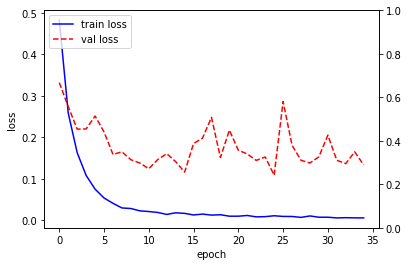

acc: 0.9647	loss: 0.1088
==========================================B_angle finished==========================================


In [4]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_1'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'B_angle'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'B_angle'
    
    saveDir = 'trained_model_B_angle'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_1 (M_angle)

>>  M_angle
=============================================ResNet-18==============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
Epoch 1/100
855/855 [==============================] - 100s 116ms/step - loss: 0.5136 - acc: 0.7447 - val_loss: 0.3800 - val_acc: 0.8546

Epoch 00001: val_loss improved from inf to 0.37999, saving model to trained_model_M_angle\M_angle-01-0.3800.hdf5
Epoch 2/100
855/855 [==============================] - 82s 95ms/step - loss: 0.3151 - acc: 0.8773 - val_loss: 0.2795 - val_acc: 0.9045

Epoch 00002: val_loss improved from 0.37999 to 0.27947, saving model to trained_model_M_angle\M_angle-02-0.2795.hdf5
Epoch 3/100
855/855 [==============================] - 82s 95ms/step - loss: 0.2276 - acc: 0.9146 - val_loss: 0.2316 - val_acc: 0.9249

Epoch 00003: val_loss improved from 0.27947 to 0.23161, saving model to trained_model_M_angle\M_angle-03-0.2316.hdf5
Epoch 4/100
855/855 [=======================

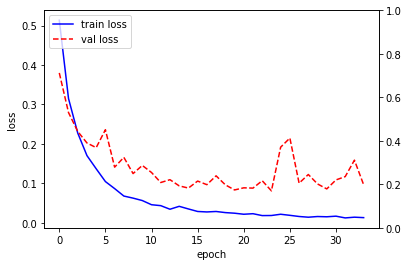

acc: 0.9680	loss: 0.0809
==========================================M_angle finished==========================================


In [5]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_1'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'M_angle'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'M_angle'
    
    saveDir = 'trained_model_M_angle'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_1 (T_angle)

>>  T_angle
=============================================ResNet-18==============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
Epoch 1/100
855/855 [==============================] - 98s 115ms/step - loss: 0.4983 - acc: 0.7625 - val_loss: 0.3548 - val_acc: 0.8880

Epoch 00001: val_loss improved from inf to 0.35481, saving model to trained_model_T_angle\T_angle-01-0.3548.hdf5
Epoch 2/100
855/855 [==============================] - 82s 96ms/step - loss: 0.2704 - acc: 0.9010 - val_loss: 0.1986 - val_acc: 0.9310

Epoch 00002: val_loss improved from 0.35481 to 0.19863, saving model to trained_model_T_angle\T_angle-02-0.1986.hdf5
Epoch 3/100
855/855 [==============================] - 82s 96ms/step - loss: 0.1902 - acc: 0.9310 - val_loss: 0.2428 - val_acc: 0.8965

Epoch 00003: val_loss did not improve from 0.19863
Epoch 4/100
855/855 [==============================] - 82s 95ms/step - loss: 0.1496 - acc: 0.9480 - val_loss: 0

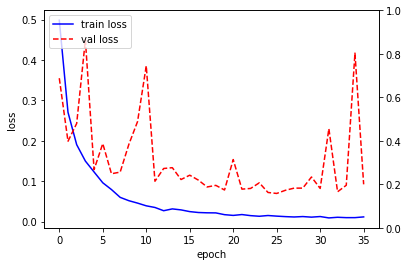

acc: 0.9739	loss: 0.0695
==========================================T_angle finished==========================================


In [6]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_1'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'T_angle'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'T_angle'
    
    saveDir = 'trained_model_T_angle'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_2 (D_distance)

>>  D_distance
=============================================ResNet-18==============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
Epoch 1/100
855/855 [==============================] - 99s 116ms/step - loss: 0.5227 - acc: 0.7368 - val_loss: 0.3876 - val_acc: 0.8465

Epoch 00001: val_loss improved from inf to 0.38756, saving model to trained_model_D_distance\D_distance-01-0.3876.hdf5
Epoch 2/100
855/855 [==============================] - 82s 96ms/step - loss: 0.3487 - acc: 0.8612 - val_loss: 0.3103 - val_acc: 0.8795

Epoch 00002: val_loss improved from 0.38756 to 0.31031, saving model to trained_model_D_distance\D_distance-02-0.3103.hdf5
Epoch 3/100
855/855 [==============================] - 82s 96ms/step - loss: 0.2736 - acc: 0.8935 - val_loss: 0.2438 - val_acc: 0.9094

Epoch 00003: val_loss improved from 0.31031 to 0.24377, saving model to trained_model_D_distance\D_distance-03-0.2438.hdf5
Epoch 4/100
855/855 [===

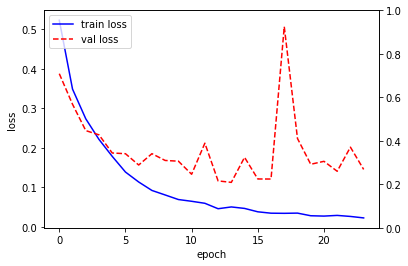

acc: 0.9578	loss: 0.1129
========================================D_distance finished=========================================


In [7]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_2'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'D_distance'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'D_distance'
    
    saveDir = 'trained_model_D_distance'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_2 (N_distance)

>>  N_distance
=============================================ResNet-18==============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
Epoch 1/100
855/855 [==============================] - 99s 116ms/step - loss: 0.5144 - acc: 0.7477 - val_loss: 0.3626 - val_acc: 0.8558

Epoch 00001: val_loss improved from inf to 0.36263, saving model to trained_model_N_distance\N_distance-01-0.3626.hdf5
Epoch 2/100
855/855 [==============================] - 82s 96ms/step - loss: 0.2980 - acc: 0.8808 - val_loss: 0.2734 - val_acc: 0.8899

Epoch 00002: val_loss improved from 0.36263 to 0.27336, saving model to trained_model_N_distance\N_distance-02-0.2734.hdf5
Epoch 3/100
855/855 [==============================] - 82s 96ms/step - loss: 0.2147 - acc: 0.9185 - val_loss: 0.2057 - val_acc: 0.9287

Epoch 00003: val_loss improved from 0.27336 to 0.20572, saving model to trained_model_N_distance\N_distance-03-0.2057.hdf5
Epoch 4/100
855/855 [===

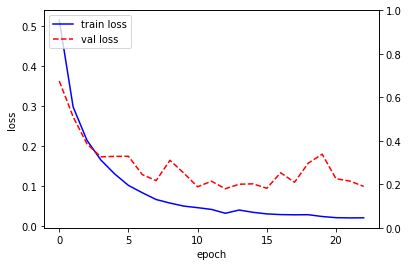

acc: 0.9657	loss: 0.0937
========================================N_distance finished=========================================


In [8]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_2'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'N_distance'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'N_distance'
    
    saveDir = 'trained_model_N_distance'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_3 (print)

>>  print
=============================================ResNet-18==============================================
Found 27360 images belonging to 2 classes.
Found 20160 images belonging to 2 classes.
Epoch 1/100
1710/1710 [==============================] - 198s 116ms/step - loss: 0.3746 - acc: 0.8467 - val_loss: 0.2778 - val_acc: 0.8742

Epoch 00001: val_loss improved from inf to 0.27776, saving model to trained_model_print\print-01-0.2778.hdf5
Epoch 2/100
1710/1710 [==============================] - 167s 97ms/step - loss: 0.1800 - acc: 0.9356 - val_loss: 0.1976 - val_acc: 0.9117

Epoch 00002: val_loss improved from 0.27776 to 0.19762, saving model to trained_model_print\print-02-0.1976.hdf5
Epoch 3/100
1710/1710 [==============================] - 167s 98ms/step - loss: 0.1173 - acc: 0.9605 - val_loss: 0.2157 - val_acc: 0.9111

Epoch 00003: val_loss did not improve from 0.19762
Epoch 4/100
1710/1710 [==============================] - 167s 98ms/step - loss: 0.0778 - acc: 0.9758 - val_loss:

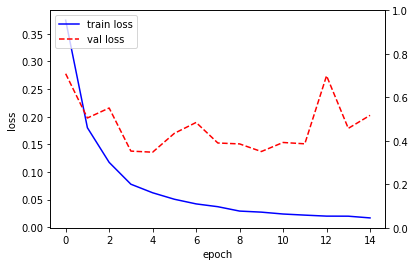

acc: 0.9501	loss: 0.1357
===========================================print finished===========================================


In [9]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_3'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'print'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'print'
    
    saveDir = 'trained_model_print'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_3 (replay)

>>  replay
=============================================ResNet-18==============================================
Found 27360 images belonging to 2 classes.
Found 20160 images belonging to 2 classes.
Epoch 1/100
1710/1710 [==============================] - 196s 115ms/step - loss: 0.4200 - acc: 0.8257 - val_loss: 0.2314 - val_acc: 0.9230

Epoch 00001: val_loss improved from inf to 0.23144, saving model to trained_model_replay\replay-01-0.2314.hdf5
Epoch 2/100
1710/1710 [==============================] - 165s 96ms/step - loss: 0.1741 - acc: 0.9406 - val_loss: 0.1491 - val_acc: 0.9440

Epoch 00002: val_loss improved from 0.23144 to 0.14911, saving model to trained_model_replay\replay-02-0.1491.hdf5
Epoch 3/100
1710/1710 [==============================] - 165s 96ms/step - loss: 0.1021 - acc: 0.9669 - val_loss: 0.1974 - val_acc: 0.9094

Epoch 00003: val_loss did not improve from 0.14911
Epoch 4/100
1710/1710 [==============================] - 165s 96ms/step - loss: 0.0658 - acc: 0.9790 - val_

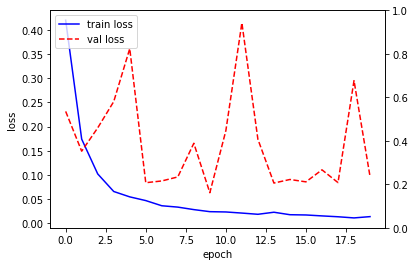

acc: 0.9787	loss: 0.0633
==========================================replay finished===========================================


In [10]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_3'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'replay'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'replay'
    
    saveDir = 'trained_model_replay'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# ResNet-18 기반 네트워크 정의

In [11]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, Activation

def ResNet18(show_layers=False, **kwargs):
    '''
    # classification_models 패키지 설치
    
    pip install git+https://github.com/qubvel/classification_models.git
    
    '''
    from classification_models.keras import Classifiers

    ResNet18, preprocess_input = Classifiers.get('resnet18')
    
    base_model = ResNet18(**kwargs)
    x = GlobalAveragePooling2D()(base_model.output)
    pred = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=pred)
    model.compile(optimizer=SGD(lr=1e-2, decay=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    if show_layers:
        for i, layer in enumerate(model.layers):
            print(i, layer.name, layer.trainable)
    
    return model

# 모델학습

# protocol_4 (total_data_test)

>>  protocol_4
=============================================ResNet-18==============================================
Found 41040 images belonging to 2 classes.
Found 30240 images belonging to 2 classes.
Epoch 1/100
2565/2565 [==============================] - 294s 115ms/step - loss: 0.1497 - acc: 0.9412 - val_loss: 0.4896 - val_acc: 0.8348

Epoch 00001: val_loss improved from inf to 0.48964, saving model to trained_model_1\protocol_4-01-0.4896.hdf5
Epoch 2/100
2565/2565 [==============================] - 248s 97ms/step - loss: 0.0412 - acc: 0.9861 - val_loss: 0.1294 - val_acc: 0.9499

Epoch 00002: val_loss improved from 0.48964 to 0.12938, saving model to trained_model_1\protocol_4-02-0.1294.hdf5
Epoch 3/100
2565/2565 [==============================] - 248s 97ms/step - loss: 0.0208 - acc: 0.9936 - val_loss: 0.1199 - val_acc: 0.9558

Epoch 00003: val_loss improved from 0.12938 to 0.11990, saving model to trained_model_1\protocol_4-03-0.1199.hdf5
Epoch 4/100
2565/2565 [===================

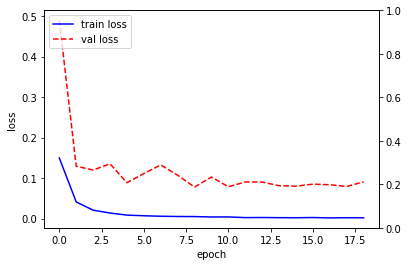

acc: 0.9727	loss: 0.0778
========================================protocol_4 finished=========================================


In [12]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'protocol_4'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'protocol_4'
    
    saveDir = 'trained_model_1'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_1 (B_angle)

>>  B_angle
=============================================ResNet-18==============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
Epoch 1/100
855/855 [==============================] - 98s 115ms/step - loss: 0.1563 - acc: 0.9400 - val_loss: 0.3193 - val_acc: 0.9185

Epoch 00001: val_loss improved from inf to 0.31933, saving model to trained_model_B_angle_1\B_angle-01-0.3193.hdf5
Epoch 2/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0340 - acc: 0.9900 - val_loss: 0.2547 - val_acc: 0.9411

Epoch 00002: val_loss improved from 0.31933 to 0.25468, saving model to trained_model_B_angle_1\B_angle-02-0.2547.hdf5
Epoch 3/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0188 - acc: 0.9953 - val_loss: 0.1601 - val_acc: 0.9630

Epoch 00003: val_loss improved from 0.25468 to 0.16007, saving model to trained_model_B_angle_1\B_angle-03-0.1601.hdf5
Epoch 4/100
855/855 [==================

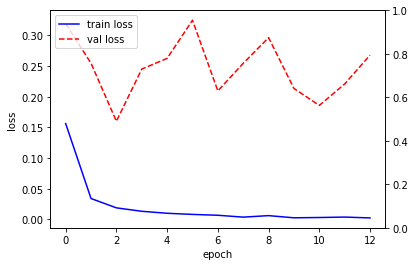

acc: 0.9630	loss: 0.1601
==========================================B_angle finished==========================================


In [13]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_1'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'B_angle'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'B_angle'
    
    saveDir = 'trained_model_B_angle_1'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_1 (M_angle)

>>  M_angle
=============================================ResNet-18==============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
Epoch 1/100
855/855 [==============================] - 100s 117ms/step - loss: 0.2158 - acc: 0.9085 - val_loss: 0.2757 - val_acc: 0.9129

Epoch 00001: val_loss improved from inf to 0.27565, saving model to trained_model_M_angle_1\M_angle-01-0.2757.hdf5
Epoch 2/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0776 - acc: 0.9710 - val_loss: 0.4709 - val_acc: 0.8679

Epoch 00002: val_loss did not improve from 0.27565
Epoch 3/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0458 - acc: 0.9854 - val_loss: 0.1605 - val_acc: 0.9491

Epoch 00003: val_loss improved from 0.27565 to 0.16046, saving model to trained_model_M_angle_1\M_angle-03-0.1605.hdf5
Epoch 4/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0254 - acc: 0.9921 - val_lo

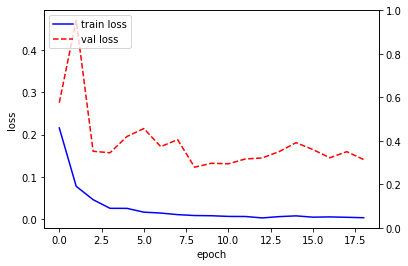

acc: 0.9658	loss: 0.1228
==========================================M_angle finished==========================================


In [14]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_1'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'M_angle'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'M_angle'
    
    saveDir = 'trained_model_M_angle_1'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_1 (T_angle)

>>  T_angle
=============================================ResNet-18==============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
Epoch 1/100
855/855 [==============================] - 100s 117ms/step - loss: 0.1883 - acc: 0.9251 - val_loss: 0.1278 - val_acc: 0.9571

Epoch 00001: val_loss improved from inf to 0.12776, saving model to trained_model_T_angle_1\T_angle-01-0.1278.hdf5
Epoch 2/100
855/855 [==============================] - 83s 97ms/step - loss: 0.0517 - acc: 0.9838 - val_loss: 0.2581 - val_acc: 0.9215

Epoch 00002: val_loss did not improve from 0.12776
Epoch 3/100
855/855 [==============================] - 83s 97ms/step - loss: 0.0325 - acc: 0.9903 - val_loss: 0.1613 - val_acc: 0.9625

Epoch 00003: val_loss did not improve from 0.12776
Epoch 4/100
855/855 [==============================] - 83s 97ms/step - loss: 0.0191 - acc: 0.9943 - val_loss: 0.6787 - val_acc: 0.7959

Epoch 00004: val_loss did not improve 

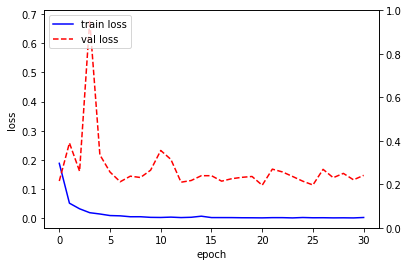

acc: 0.9748	loss: 0.1132
==========================================T_angle finished==========================================


In [15]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_1'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'T_angle'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'T_angle'
    
    saveDir = 'trained_model_T_angle_1'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_2 (D_distance)

>>  D_distance
=============================================ResNet-18==============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
Epoch 1/100
855/855 [==============================] - 98s 115ms/step - loss: 0.2702 - acc: 0.8878 - val_loss: 0.2108 - val_acc: 0.9190

Epoch 00001: val_loss improved from inf to 0.21076, saving model to trained_model_D_distance_1\D_distance-01-0.2108.hdf5
Epoch 2/100
855/855 [==============================] - 82s 96ms/step - loss: 0.1078 - acc: 0.9602 - val_loss: 0.1665 - val_acc: 0.9378

Epoch 00002: val_loss improved from 0.21076 to 0.16654, saving model to trained_model_D_distance_1\D_distance-02-0.1665.hdf5
Epoch 3/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0595 - acc: 0.9799 - val_loss: 0.1433 - val_acc: 0.9436

Epoch 00003: val_loss improved from 0.16654 to 0.14326, saving model to trained_model_D_distance_1\D_distance-03-0.1433.hdf5
Epoch 4/100
855/85

855/855 [==============================] - 82s 96ms/step - loss: 0.0014 - acc: 0.9999 - val_loss: 0.1007 - val_acc: 0.9697

Epoch 00039: val_loss improved from 0.10170 to 0.10074, saving model to trained_model_D_distance_1\D_distance-39-0.1007.hdf5
Epoch 40/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0027 - acc: 0.9991 - val_loss: 0.1064 - val_acc: 0.9708

Epoch 00040: val_loss did not improve from 0.10074
Epoch 41/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0014 - acc: 0.9999 - val_loss: 0.1174 - val_acc: 0.9690

Epoch 00041: val_loss did not improve from 0.10074
Epoch 42/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0018 - acc: 0.9998 - val_loss: 0.1189 - val_acc: 0.9625

Epoch 00042: val_loss did not improve from 0.10074
Epoch 43/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.1074 - val_acc: 0.9687

Epoch 00043: val_loss did not improve from 0.10074

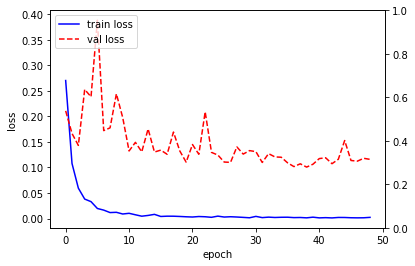

acc: 0.9697	loss: 0.1007
========================================D_distance finished=========================================


In [16]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_2'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'D_distance'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'D_distance'
    
    saveDir = 'trained_model_D_distance_1'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_2 (N_distance)

>>  N_distance
=============================================ResNet-18==============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
Epoch 1/100
855/855 [==============================] - 98s 115ms/step - loss: 0.2084 - acc: 0.9133 - val_loss: 0.3431 - val_acc: 0.8747

Epoch 00001: val_loss improved from inf to 0.34315, saving model to trained_model_N_distance_1\N_distance-01-0.3431.hdf5
Epoch 2/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0730 - acc: 0.9734 - val_loss: 0.1683 - val_acc: 0.9390

Epoch 00002: val_loss improved from 0.34315 to 0.16831, saving model to trained_model_N_distance_1\N_distance-02-0.1683.hdf5
Epoch 3/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0465 - acc: 0.9851 - val_loss: 0.2312 - val_acc: 0.9269

Epoch 00003: val_loss did not improve from 0.16831
Epoch 4/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0310 - acc: 0

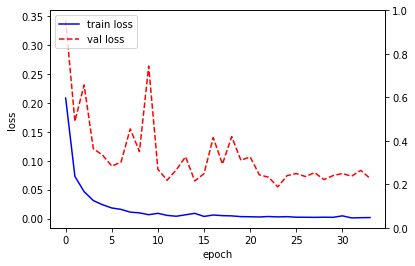

acc: 0.9797	loss: 0.0547
========================================N_distance finished=========================================


In [17]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_2'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'N_distance'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'N_distance'
    
    saveDir = 'trained_model_N_distance_1'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_3 (print)

>>  print
=============================================ResNet-18==============================================
Found 27360 images belonging to 2 classes.
Found 20160 images belonging to 2 classes.
Epoch 1/100
1710/1710 [==============================] - 197s 115ms/step - loss: 0.1434 - acc: 0.9455 - val_loss: 0.1950 - val_acc: 0.9346

Epoch 00001: val_loss improved from inf to 0.19495, saving model to trained_model_print_1\print-01-0.1950.hdf5
Epoch 2/100
1710/1710 [==============================] - 165s 97ms/step - loss: 0.0422 - acc: 0.9863 - val_loss: 0.1201 - val_acc: 0.9604

Epoch 00002: val_loss improved from 0.19495 to 0.12011, saving model to trained_model_print_1\print-02-0.1201.hdf5
Epoch 3/100
1710/1710 [==============================] - 165s 97ms/step - loss: 0.0244 - acc: 0.9921 - val_loss: 0.1985 - val_acc: 0.9577

Epoch 00003: val_loss did not improve from 0.12011
Epoch 4/100
1710/1710 [==============================] - 165s 97ms/step - loss: 0.0128 - acc: 0.9964 - val_l

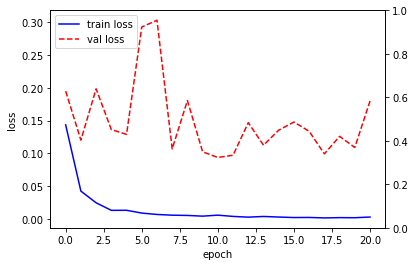

acc: 0.9621	loss: 0.0936
===========================================print finished===========================================


In [18]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_3'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'print'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'print'
    
    saveDir = 'trained_model_print_1'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_3 (replay)

>>  replay
=============================================ResNet-18==============================================
Found 27360 images belonging to 2 classes.
Found 20160 images belonging to 2 classes.
Epoch 1/100
1710/1710 [==============================] - 196s 115ms/step - loss: 0.1429 - acc: 0.9446 - val_loss: 0.4186 - val_acc: 0.8611

Epoch 00001: val_loss improved from inf to 0.41864, saving model to trained_model_replay_1\replay-01-0.4186.hdf5
Epoch 2/100
1710/1710 [==============================] - 164s 96ms/step - loss: 0.0372 - acc: 0.9871 - val_loss: 0.0710 - val_acc: 0.9792

Epoch 00002: val_loss improved from 0.41864 to 0.07100, saving model to trained_model_replay_1\replay-02-0.0710.hdf5
Epoch 3/100
1710/1710 [==============================] - 164s 96ms/step - loss: 0.0222 - acc: 0.9934 - val_loss: 0.1441 - val_acc: 0.9586

Epoch 00003: val_loss did not improve from 0.07100
Epoch 4/100
1710/1710 [==============================] - 164s 96ms/step - loss: 0.0149 - acc: 0.9958 - 

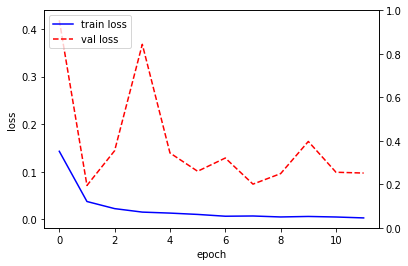

acc: 0.9792	loss: 0.0710
==========================================replay finished===========================================


In [19]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_3'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'replay'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'replay'
    
    saveDir = 'trained_model_replay_1'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# ResNet-18 기반 네트워크 정의

In [20]:
from keras.models import Model
from keras.layers import Input, GlobalAveragePooling2D, Dense, Activation

def ResNet18(show_layers=False, **kwargs):
    '''
    # classification_models 패키지 설치
    
    pip install git+https://github.com/qubvel/classification_models.git
    
    '''
    from classification_models.keras import Classifiers

    ResNet18, preprocess_input = Classifiers.get('resnet18')
    
    base_model = ResNet18(**kwargs)
    x = GlobalAveragePooling2D()(base_model.output)
    pred = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=pred)
    model.compile(optimizer=SGD(lr=5e-3, decay=5e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    if show_layers:
        for i, layer in enumerate(model.layers):
            print(i, layer.name, layer.trainable)
    
    return model

# 모델학습

# protocol_4

>>  protocol_4
=============================================ResNet-18==============================================
Found 41040 images belonging to 2 classes.
Found 30240 images belonging to 2 classes.
Epoch 1/100
2565/2565 [==============================] - 292s 114ms/step - loss: 0.1875 - acc: 0.9250 - val_loss: 0.2419 - val_acc: 0.9145

Epoch 00001: val_loss improved from inf to 0.24189, saving model to trained_model_2\protocol_4-01-0.2419.hdf5
Epoch 2/100
2565/2565 [==============================] - 247s 96ms/step - loss: 0.0605 - acc: 0.9793 - val_loss: 0.1518 - val_acc: 0.9461

Epoch 00002: val_loss improved from 0.24189 to 0.15178, saving model to trained_model_2\protocol_4-02-0.1518.hdf5
Epoch 3/100
2565/2565 [==============================] - 247s 96ms/step - loss: 0.0348 - acc: 0.9888 - val_loss: 0.1461 - val_acc: 0.9540

Epoch 00003: val_loss improved from 0.15178 to 0.14610, saving model to trained_model_2\protocol_4-03-0.1461.hdf5
Epoch 4/100
2565/2565 [===================

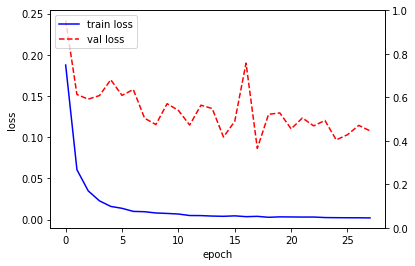

acc: 0.9710	loss: 0.0864
========================================protocol_4 finished=========================================


In [21]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'protocol_4'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'protocol_4'
    
    saveDir = 'trained_model_2'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_1 (B_angle)

>>  B_angle
=============================================ResNet-18==============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
Epoch 1/100
855/855 [==============================] - 99s 116ms/step - loss: 0.2328 - acc: 0.9066 - val_loss: 0.2452 - val_acc: 0.9223

Epoch 00001: val_loss improved from inf to 0.24525, saving model to trained_model_B_angle_2\B_angle-01-0.2452.hdf5
Epoch 2/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0553 - acc: 0.9844 - val_loss: 0.1414 - val_acc: 0.9543

Epoch 00002: val_loss improved from 0.24525 to 0.14135, saving model to trained_model_B_angle_2\B_angle-02-0.1414.hdf5
Epoch 3/100
855/855 [==============================] - 83s 97ms/step - loss: 0.0314 - acc: 0.9919 - val_loss: 0.1489 - val_acc: 0.9611

Epoch 00003: val_loss did not improve from 0.14135
Epoch 4/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0219 - acc: 0.9937 - val_los

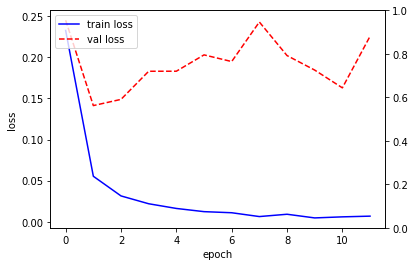

acc: 0.9543	loss: 0.1414
==========================================B_angle finished==========================================


In [22]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_1'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'B_angle'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'B_angle'
    
    saveDir = 'trained_model_B_angle_2'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_1 (M_angle)

>>  M_angle
=============================================ResNet-18==============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
Epoch 1/100
855/855 [==============================] - 99s 116ms/step - loss: 0.2855 - acc: 0.8762 - val_loss: 0.4362 - val_acc: 0.8523

Epoch 00001: val_loss improved from inf to 0.43620, saving model to trained_model_M_angle_2\M_angle-01-0.4362.hdf5
Epoch 2/100
855/855 [==============================] - 82s 96ms/step - loss: 0.1109 - acc: 0.9594 - val_loss: 0.2133 - val_acc: 0.9248

Epoch 00002: val_loss improved from 0.43620 to 0.21326, saving model to trained_model_M_angle_2\M_angle-02-0.2133.hdf5
Epoch 3/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0678 - acc: 0.9781 - val_loss: 0.1639 - val_acc: 0.9405

Epoch 00003: val_loss improved from 0.21326 to 0.16387, saving model to trained_model_M_angle_2\M_angle-03-0.1639.hdf5
Epoch 4/100
855/855 [==================

855/855 [==============================] - 82s 96ms/step - loss: 0.0040 - acc: 0.9988 - val_loss: 0.1033 - val_acc: 0.9649

Epoch 00040: val_loss did not improve from 0.09048


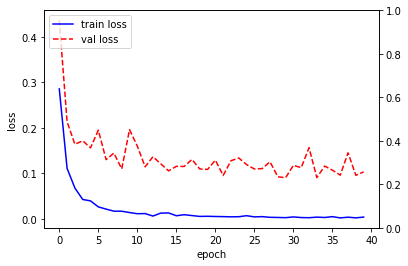

acc: 0.9687	loss: 0.0905
==========================================M_angle finished==========================================


In [23]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_1'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'M_angle'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'M_angle'
    
    saveDir = 'trained_model_M_angle_2'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_1 (T_angle)

>>  T_angle
=============================================ResNet-18==============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
Epoch 1/100
855/855 [==============================] - 99s 116ms/step - loss: 0.2568 - acc: 0.8962 - val_loss: 0.1340 - val_acc: 0.9599

Epoch 00001: val_loss improved from inf to 0.13397, saving model to trained_model_T_angle_2\T_angle-01-0.1340.hdf5
Epoch 2/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0870 - acc: 0.9705 - val_loss: 0.1486 - val_acc: 0.9524

Epoch 00002: val_loss did not improve from 0.13397
Epoch 3/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0524 - acc: 0.9845 - val_loss: 0.1185 - val_acc: 0.9603

Epoch 00003: val_loss improved from 0.13397 to 0.11847, saving model to trained_model_T_angle_2\T_angle-03-0.1185.hdf5
Epoch 4/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0331 - acc: 0.9903 - val_los

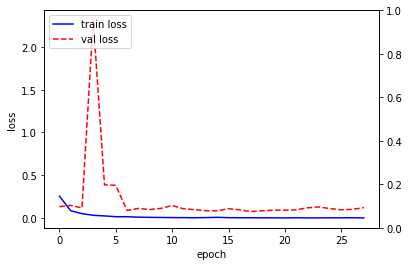

acc: 0.9772	loss: 0.0762
==========================================T_angle finished==========================================


In [24]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_1'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'T_angle'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'T_angle'
    
    saveDir = 'trained_model_T_angle_2'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_2 (D_distance)

>>  D_distance
=============================================ResNet-18==============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
Epoch 1/100
855/855 [==============================] - 99s 116ms/step - loss: 0.3290 - acc: 0.8616 - val_loss: 0.2215 - val_acc: 0.9207

Epoch 00001: val_loss improved from inf to 0.22146, saving model to trained_model_D_distance_2\D_distance-01-0.2215.hdf5
Epoch 2/100
855/855 [==============================] - 82s 96ms/step - loss: 0.1480 - acc: 0.9452 - val_loss: 0.1809 - val_acc: 0.9242

Epoch 00002: val_loss improved from 0.22146 to 0.18090, saving model to trained_model_D_distance_2\D_distance-02-0.1809.hdf5
Epoch 3/100
855/855 [==============================] - 82s 96ms/step - loss: 0.0910 - acc: 0.9678 - val_loss: 0.1568 - val_acc: 0.9339

Epoch 00003: val_loss improved from 0.18090 to 0.15680, saving model to trained_model_D_distance_2\D_distance-03-0.1568.hdf5
Epoch 4/100
855/85

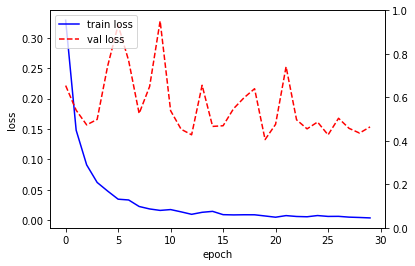

acc: 0.9567	loss: 0.1326
========================================D_distance finished=========================================


In [25]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_2'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'D_distance'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'D_distance'
    
    saveDir = 'trained_model_D_distance_2'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_2 (N_distance)

>>  N_distance
=============================================ResNet-18==============================================
Found 13680 images belonging to 2 classes.
Found 10080 images belonging to 2 classes.
Epoch 1/100
855/855 [==============================] - 99s 116ms/step - loss: 0.2771 - acc: 0.8827 - val_loss: 0.2181 - val_acc: 0.9261

Epoch 00001: val_loss improved from inf to 0.21813, saving model to trained_model_N_distance_2\N_distance-01-0.2181.hdf5
Epoch 2/100
855/855 [==============================] - 83s 97ms/step - loss: 0.1032 - acc: 0.9621 - val_loss: 0.2347 - val_acc: 0.8998

Epoch 00002: val_loss did not improve from 0.21813
Epoch 3/100
855/855 [==============================] - 83s 97ms/step - loss: 0.0655 - acc: 0.9779 - val_loss: 0.1270 - val_acc: 0.9612

Epoch 00003: val_loss improved from 0.21813 to 0.12699, saving model to trained_model_N_distance_2\N_distance-03-0.1270.hdf5
Epoch 4/100
855/855 [==============================] - 83s 97ms/step - loss: 0.0470 - acc: 0

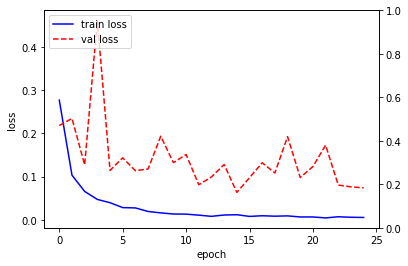

acc: 0.9798	loss: 0.0633
========================================N_distance finished=========================================


In [26]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_2'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'N_distance'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'N_distance'
    
    saveDir = 'trained_model_N_distance_2'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_3 (print)

>>  print
=============================================ResNet-18==============================================
Found 27360 images belonging to 2 classes.
Found 20160 images belonging to 2 classes.
Epoch 1/100
1710/1710 [==============================] - 196s 115ms/step - loss: 0.1867 - acc: 0.9294 - val_loss: 0.2134 - val_acc: 0.9184

Epoch 00001: val_loss improved from inf to 0.21345, saving model to trained_model_print_2\print-01-0.2134.hdf5
Epoch 2/100
1710/1710 [==============================] - 164s 96ms/step - loss: 0.0581 - acc: 0.9808 - val_loss: 0.1438 - val_acc: 0.9457

Epoch 00002: val_loss improved from 0.21345 to 0.14384, saving model to trained_model_print_2\print-02-0.1438.hdf5
Epoch 3/100
1710/1710 [==============================] - 164s 96ms/step - loss: 0.0363 - acc: 0.9882 - val_loss: 0.1894 - val_acc: 0.9447

Epoch 00003: val_loss did not improve from 0.14384
Epoch 4/100
1710/1710 [==============================] - 164s 96ms/step - loss: 0.0212 - acc: 0.9941 - val_l

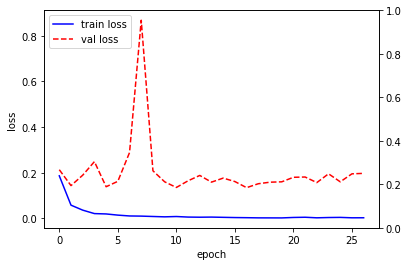

acc: 0.9638	loss: 0.1349
===========================================print finished===========================================


In [27]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_3'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'print'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'print'
    
    saveDir = 'trained_model_print_2'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()

# protocol_3 (replay)

>>  replay
=============================================ResNet-18==============================================
Found 27360 images belonging to 2 classes.
Found 20160 images belonging to 2 classes.
Epoch 1/100
1710/1710 [==============================] - 196s 115ms/step - loss: 0.1912 - acc: 0.9249 - val_loss: 0.1742 - val_acc: 0.9380

Epoch 00001: val_loss improved from inf to 0.17424, saving model to trained_model_replay_2\replay-01-0.1742.hdf5
Epoch 2/100
1710/1710 [==============================] - 165s 97ms/step - loss: 0.0518 - acc: 0.9827 - val_loss: 0.0717 - val_acc: 0.9774

Epoch 00002: val_loss improved from 0.17424 to 0.07174, saving model to trained_model_replay_2\replay-02-0.0717.hdf5
Epoch 3/100
1710/1710 [==============================] - 165s 97ms/step - loss: 0.0349 - acc: 0.9885 - val_loss: 0.1725 - val_acc: 0.9516

Epoch 00003: val_loss did not improve from 0.07174
Epoch 4/100
1710/1710 [==============================] - 165s 97ms/step - loss: 0.0219 - acc: 0.9935 - 

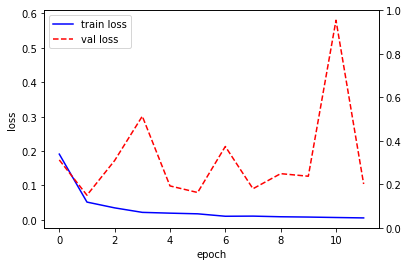

acc: 0.9774	loss: 0.0717
==========================================replay finished===========================================


In [28]:
import glob
import os
import numpy as np
import cv2
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.utils import class_weight

%matplotlib inline
SEED = 777

def main():
    inputSize = 224
    batchSize = 16
    nEpoch = 100
    
    # 디렉토리 정보 설정
    # dataDir = 'D:\\Face_Database\\B-Database'
    dataDir = 'C:\\Users\\prlab\\Desktop\\bjy\\protocol_3'   
    # 학습 및 테스트 할 데이터베이스 디렉토리명
    trainDB = 'replay'  # D:\Face_Database\B-Database\protocol_4\train
    validDB = 'replay'
    
    saveDir = 'trained_model_replay_2'
    if not os.path.exists(saveDir):    
        os.makedirs(saveDir)
    model_path = os.path.join(saveDir, trainDB + '-{epoch:02d}-{val_loss:.4f}.hdf5')
    
    # 데이터베이스별 학습 수행
    print('>> ', trainDB)
    np.random.seed(SEED)

    print('ResNet-18'.center(100, '='))
    
    '''
    training
    '''
    K.clear_session()

    # 네트워크 정의
    model = ResNet18(input_shape=(inputSize, inputSize, 3), weights=None, include_top=False)

    # 데이터 generator 생성
    train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       horizontal_flip=True,)
    train_generator = train_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'train']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=True,)

    valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
    valid_generator = valid_datagen.flow_from_directory(os.path.join(*[dataDir, trainDB, 'val']),
                                                        target_size=(inputSize, inputSize),
                                                        batch_size=batchSize,
                                                        class_mode='binary',
                                                        interpolation='bilinear',
                                                        shuffle=False,)


    # unbalanced class를 해결하기 위한 class_weight 설정
    class_weights = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)

    # callback 함수 정의
    early_stop = EarlyStopping(patience=10, monitor='val_loss')
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)

    # 모델 학습
    hist = model.fit_generator(train_generator, 
                               epochs=nEpoch,
                               steps_per_epoch=len(train_generator),
                               class_weight=class_weights,
                               validation_data=valid_generator,
                               validation_steps=len(valid_generator),
                               verbose=1,
                               callbacks=[early_stop, cb_checkpoint])

    
    # 학습 결과 그래프 그리기
    import matplotlib.pyplot as plt

    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'b', label='train loss')
    loss_ax.plot(hist.history['val_loss'], '--r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    plt.show()
    print('acc: {:.4f}\tloss: {:.4f}'.format(hist.history['val_acc'][-11], hist.history['val_loss'][-11]))

    print(('{} finished'.format(trainDB)).center(100,'='))

        
if __name__ == '__main__':
    main()